### 机器学习
- 模型构建：得自己写
- 模型权重求解：得自己写
- 使用情况：直接调包：scikit-learn/ lightgbm/xgboost/catboost

### 深度学习
- 模型构建：得自己写
- 模型权重求解：框架打包好了
- 使用情况：大量的基于框架（torch/paddle/tesnorflow/...）开发


# torch 开发流程
### 1.数据准备
- 数据编码
- 让计算机认识原始数据
- Dataset类构建
- 利用torch的能力来做到一次取一个batch的数据
### 2.模型设计
- 需要和Dataloader吐出来的数据形式对齐
- 实现模型里面的子模块
  1. 继承 nn.moudle
  2. 实现 forward
- 把子模块拼成最终的模型
### 3.跑模型流程
- 八股文(不太需要定制化开发)
- 训练流程
- 验证/测试流程

In [23]:
import torch
from torch.utils.data import Dataset
from torch.nn.init import xavier_normal_, constant_
import torch.utils.data as D
from torch import nn
import pandas as pd
import numpy as np
import copy
import os
from tqdm.notebook import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
from loguru import logger
from sklearn.model_selection import GridSearchCV,cross_val_score,KFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [24]:
# 参数配置 参数与模型分离 -> 高效调参
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device_gpu)

config = { # 偏数据集本身的配置
    "train_path":'data/used_car_train_20200313.csv', # 训练集路径
    "test_path":'data/used_car_testB_20200421.csv', # 测试集路径
    "epoch" : 5, # 训练周期
    "batch_size" : 512, # 批量大小
    "lr" : 0.001, # 学习率
    "model_ckpt_dir":'./', # 模型检查点路径 -> 当前所在目录
    "device" : 'cuda:0', # 训练设备
    # numerical_cols 连续特征
    "num_cols" : ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
    # categorical_cols 离散特征
    "cate_cols" : ['model','brand','bodyType','fuelType','gearbox','seller','notRepairedDamage']
}

model_config = {
    "is_use_cate_cols": True, # 是否使用 cate_cols 离散特征
    "embedding_dim": 4, # 离散特征词嵌入向量的维度 深度学习中对离散特征处理的基础逻辑
    "hidden_units": [256, 128, 64, 32], # 隐藏层单元 - 每一层的 units 个数
    "num_cols": config['num_cols'],
    # 'cate_cols': config['cate_cols'],
    "cate_cols": config['cate_cols'] # 此处使用的单双引号没有区别, 都可以
}
model_config['cate_cols']

device cuda:0


['model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'seller',
 'notRepairedDamage']

In [25]:
# 将数据集读取为 dataframe 结构
train_df = pd.read_csv(config['train_path'],sep=' ') # 读取训练数据, 包含 price
test_df = pd.read_csv(config['test_path'],sep=' ') # 读取测试数据
train_df.info

<bound method DataFrame.info of         SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0            0     736  20040402   30.0      6       1.0       0.0      0.0   
1            1    2262  20030301   40.0      1       2.0       0.0      0.0   
2            2   14874  20040403  115.0     15       1.0       0.0      0.0   
3            3   71865  19960908  109.0     10       0.0       0.0      1.0   
4            4  111080  20120103  110.0      5       1.0       0.0      0.0   
...        ...     ...       ...    ...    ...       ...       ...      ...   
149995  149995  163978  20000607  121.0     10       4.0       0.0      1.0   
149996  149996  184535  20091102  116.0     11       0.0       0.0      0.0   
149997  149997  147587  20101003   60.0     11       1.0       1.0      0.0   
149998  149998   45907  20060312   34.0     10       3.0       1.0      0.0   
149999  149999  177672  19990204   19.0     28       6.0       0.0      1.0   

        power  kilo

In [26]:
# 拼接合并训练df与测试df
df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True) #  上下拼接, 重置并丢弃原来的索引
df.info() # 查看df信息, 包含 price

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             200000 non-null  int64  
 1   name               200000 non-null  int64  
 2   regDate            200000 non-null  int64  
 3   model              199999 non-null  float64
 4   brand              200000 non-null  int64  
 5   bodyType           193990 non-null  float64
 6   fuelType           188396 non-null  float64
 7   gearbox            192051 non-null  float64
 8   power              200000 non-null  int64  
 9   kilometer          200000 non-null  float64
 10  notRepairedDamage  200000 non-null  object 
 11  regionCode         200000 non-null  int64  
 12  seller             200000 non-null  int64  
 13  offerType          200000 non-null  int64  
 14  creatDate          200000 non-null  int64  
 15  price              150000 non-null  float64
 16  v_

In [27]:
# 连续特征异常值简单处理
df.loc[df['power']>600,'power'] = 600 # 发动机功率限制, [0, 600] 

## 1. 简易EDA(Explore data analysis 数据探索性分析) 

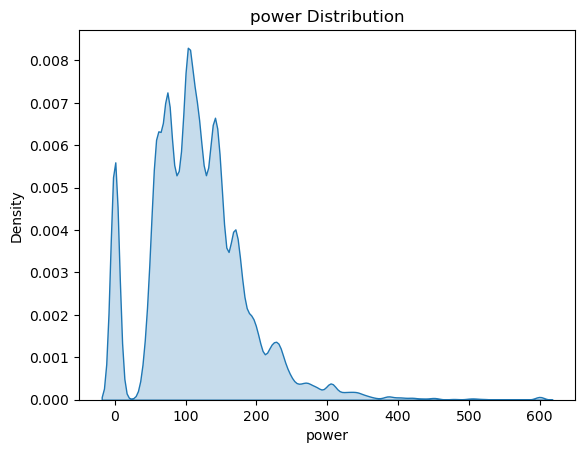

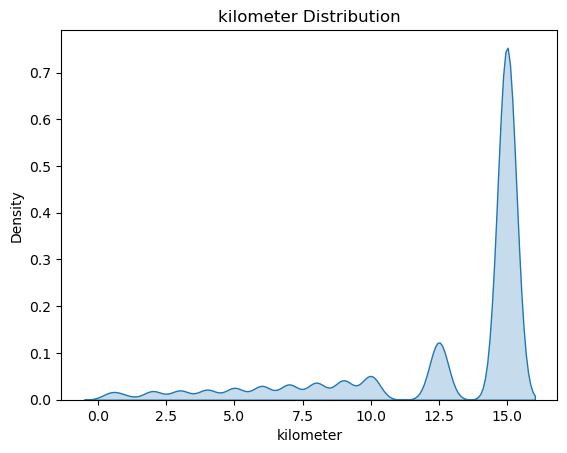

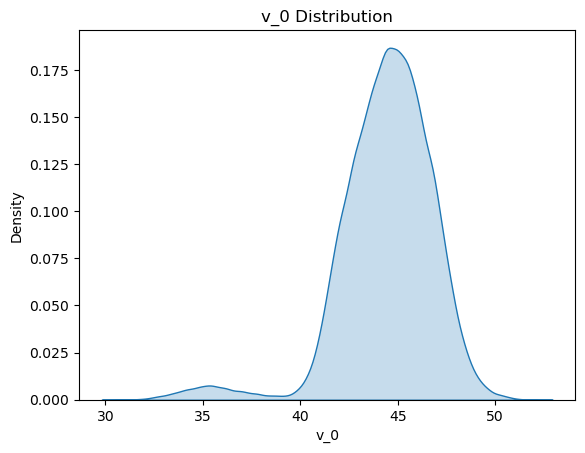

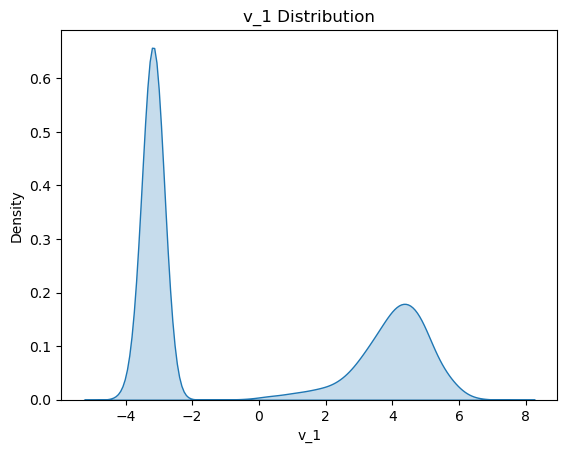

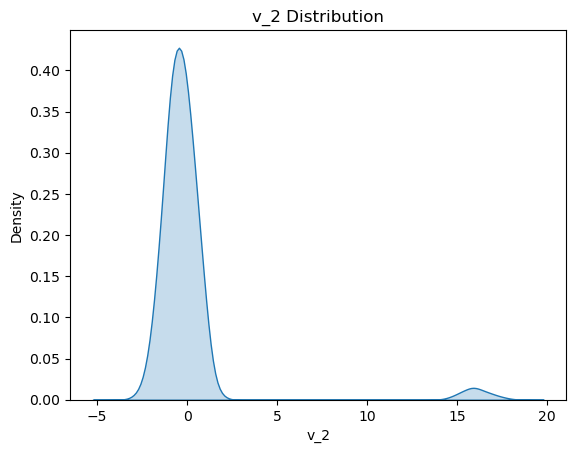

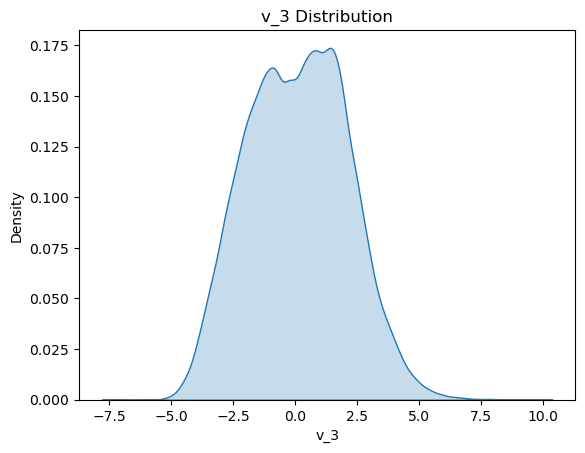

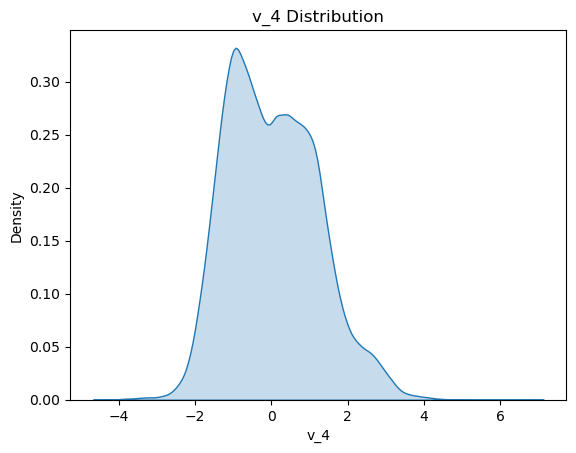

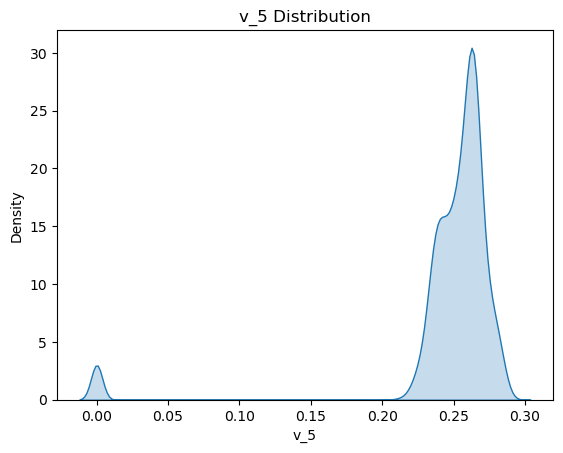

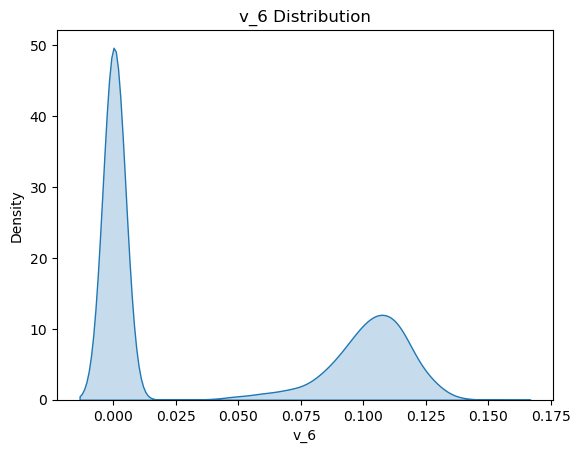

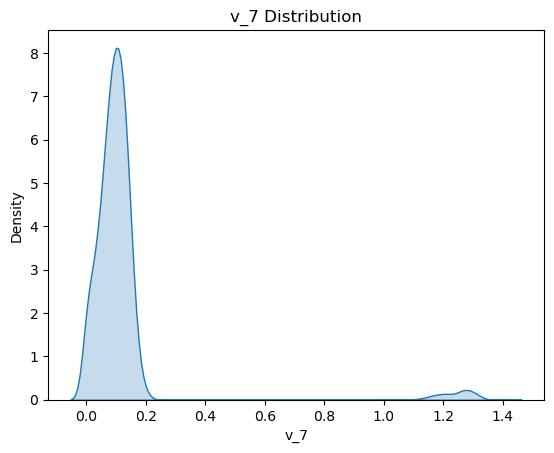

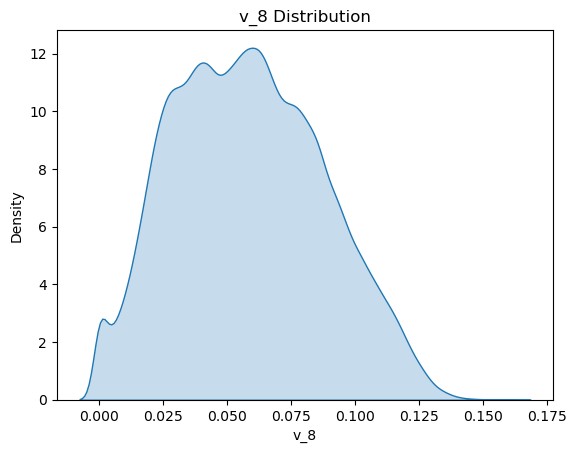

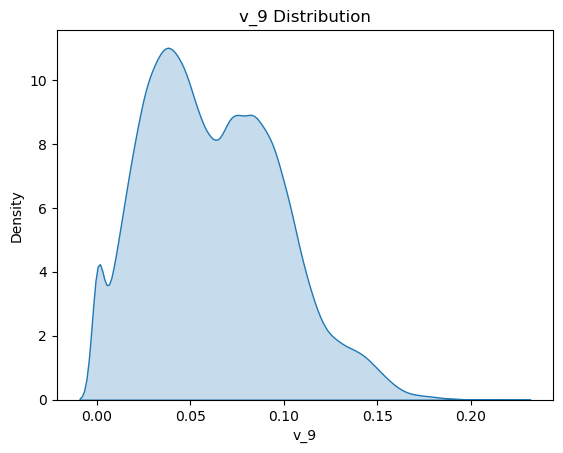

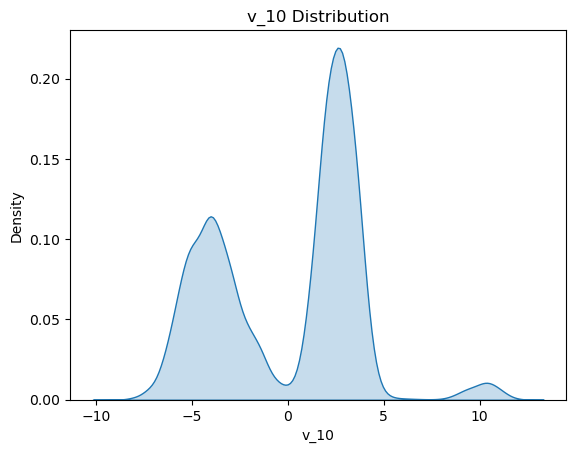

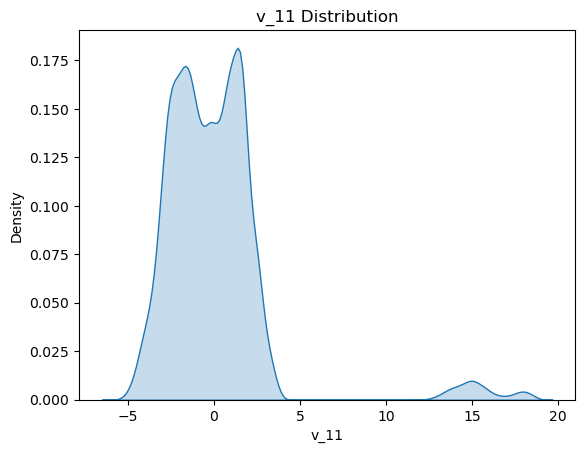

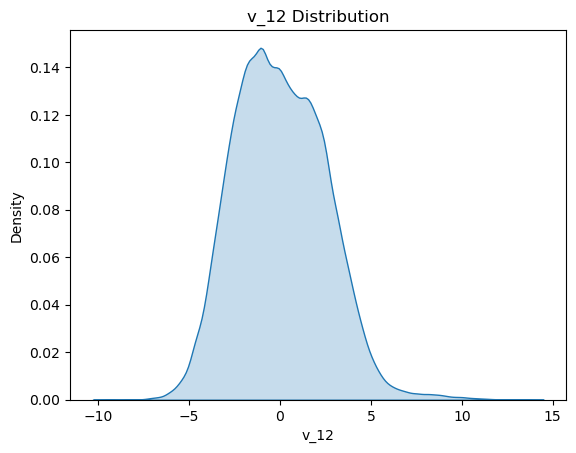

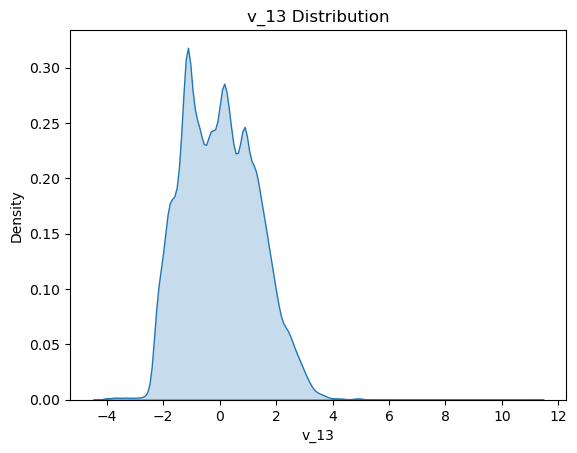

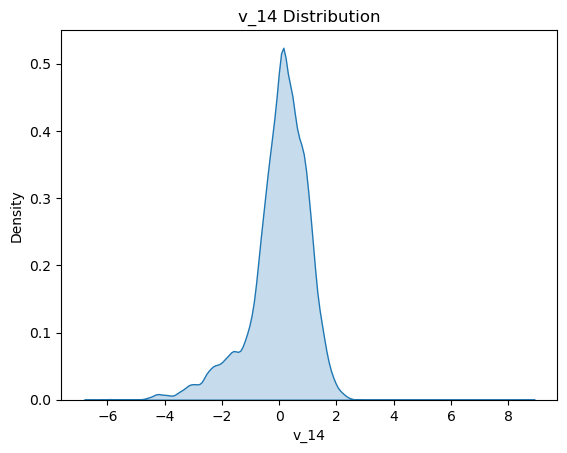

In [28]:
# 连续特征
# "num_cols" : ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
# 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
for col in config['num_cols']:
    # 绘制密度图
    sns.kdeplot(df[col], fill=True) # seaborn kdeplot(核密度估计图)

    # 设置图形标题和标签
    plt.title(f'{col} Distribution') # {col} 分布
    plt.xlabel(col)
    plt.ylabel('Density') # 密度
    
    plt.show()

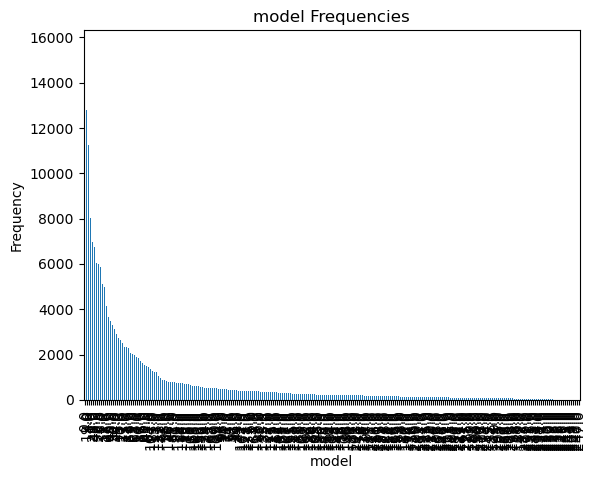

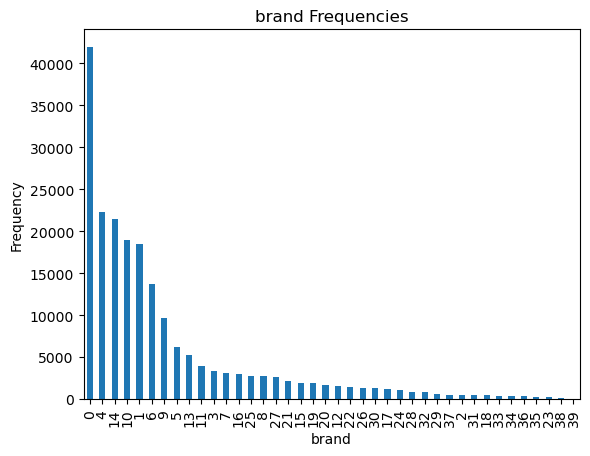

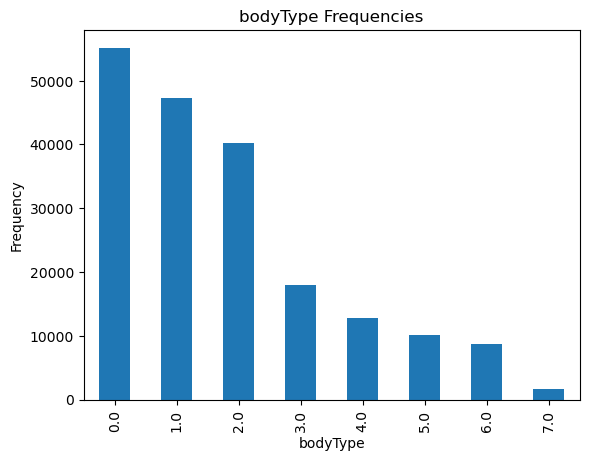

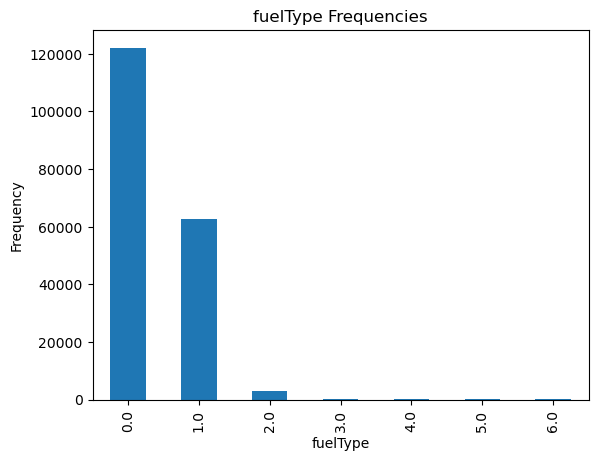

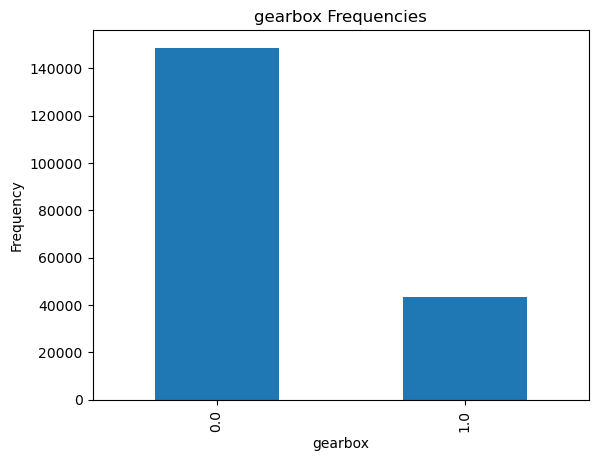

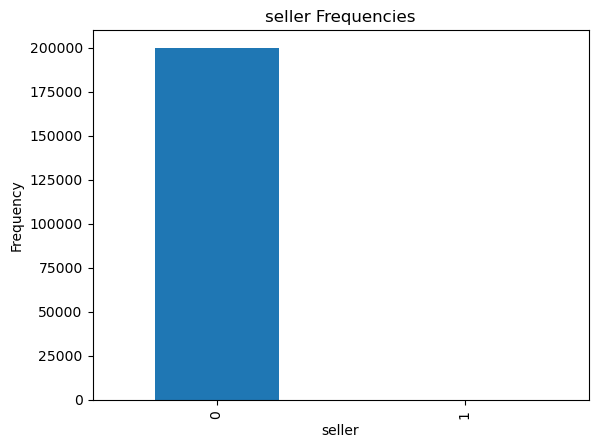

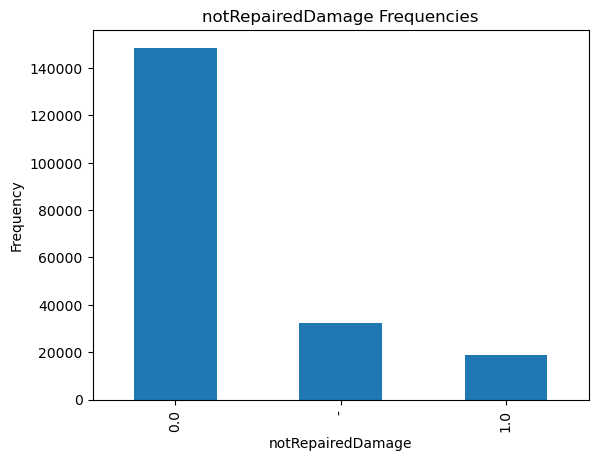

In [29]:
# 离散特征
# "cate_cols" : ['model','brand','bodyType','fuelType','gearbox','seller','notRepairedDamage']
for col in config['cate_cols']:
    # 统计特征频次
    counts = df[col].value_counts()

    # 绘制条形图
    counts.plot(kind='bar') # kind='bar' 条形图

    # 设置图形标题和标签
    plt.title(f'{col} Frequencies')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # 显示图形
    plt.show()

## 2. 简易特征编码

In [30]:
# 特征编码中不包含 price
# 重新设定一下df,避免多次运行后的df改变
# 拼接合并训练df与测试df
df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True) #  上下拼接, 重置并丢弃原来的索引

# 离散特征编码
# "cate_cols" : ['model','brand','bodyType','fuelType','gearbox','seller','notRepairedDamage']
vocab_map = defaultdict(dict) # key 为dict, 若不存在对应的key, 则返回默认构造函数的实例对象
print(vocab_map)
for col in tqdm(config['cate_cols']): # tqdm 进度条 对7个类型进行处理
    df[col] = df[col].fillna('-1') # 将缺省值用 -1(离散型, 随便填)填充  数据清洗 
    # 将两个列表合并成一个字典  .unique() 去重  .nunique() 获取唯一值的统计次数
    map_dict = dict(zip(df[col].unique(), range(df[col].nunique()))) # 映射字典 去重并给出顺序组成字典
    print(map_dict) # unique() 统计每个类别中不重复的数量 zip 接受任意多个序列作为参数返回一个tuple列表
    # label enc
    df[col] = df[col].map(map_dict) # 使用 map_dict 对列做映射, 映射为编码
    # print(df)
    # vocab_size 离散特征中不同取值的个数  在vocab_map[col]中添加 'vocab_size' 键值对
    vocab_map[col]['vocab_size'] = len(map_dict) # col: {'vocab_size': len(map_dict)}
    print(vocab_map )
model_config['vocab_map'] = vocab_map # 将离散特征添加进模型配置

defaultdict(<class 'dict'>, {})


  0%|          | 0/7 [00:00<?, ?it/s]

{30.0: 0, 40.0: 1, 115.0: 2, 109.0: 3, 110.0: 4, 24.0: 5, 13.0: 6, 26.0: 7, 19.0: 8, 7.0: 9, 1.0: 10, 48.0: 11, 65.0: 12, 138.0: 13, 105.0: 14, 114.0: 15, 0.0: 16, 8.0: 17, 78.0: 18, 21.0: 19, 3.0: 20, 4.0: 21, 31.0: 22, 121.0: 23, 75.0: 24, 17.0: 25, 107.0: 26, 16.0: 27, 111.0: 28, 47.0: 29, 5.0: 30, 44.0: 31, 200.0: 32, 155.0: 33, 87.0: 34, 20.0: 35, 22.0: 36, 63.0: 37, 49.0: 38, 29.0: 39, 88.0: 40, 60.0: 41, 73.0: 42, 39.0: 43, 23.0: 44, 11.0: 45, 69.0: 46, 167.0: 47, 199.0: 48, 178.0: 49, 101.0: 50, 6.0: 51, 10.0: 52, 57.0: 53, 33.0: 54, 32.0: 55, 52.0: 56, 46.0: 57, 74.0: 58, 93.0: 59, 125.0: 60, 41.0: 61, 127.0: 62, 104.0: 63, 98.0: 64, 68.0: 65, 156.0: 66, 116.0: 67, 170.0: 68, 160.0: 69, 85.0: 70, 80.0: 71, 143.0: 72, 77.0: 73, 166.0: 74, 53.0: 75, 66.0: 76, 203.0: 77, 14.0: 78, 42.0: 79, 119.0: 80, 174.0: 81, 177.0: 82, 210.0: 83, 36.0: 84, 238.0: 85, 70.0: 86, 58.0: 87, 126.0: 88, 84.0: 89, 97.0: 90, 108.0: 91, 192.0: 92, 64.0: 93, 15.0: 94, 95.0: 95, 54.0: 96, 142.0: 97, 55.

In [31]:
df # 离散特征已被映射为编码

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,0,0,0,0,0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,1,1,1,0,0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,2,2,0,0,0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,3,3,2,0,1,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,4,4,0,0,0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,249995,111443,20041005,21,5,2,2,1,150,15.0,...,0.263668,0.000292,0.141804,0.076393,0.039272,2.072901,-2.531869,1.716978,-1.063437,0.326587
199996,249996,152834,20130409,12,1,2,0,0,179,4.0,...,0.255310,0.000991,0.155868,0.108425,0.067841,1.358504,-3.290295,4.269809,0.140524,0.556221
199997,249997,132531,20041211,21,5,2,0,1,147,12.5,...,0.262933,0.000318,0.141872,0.071968,0.042966,2.165658,-2.417885,1.370612,-1.073133,0.270602
199998,249998,143405,20020702,1,1,8,0,1,176,15.0,...,0.282106,0.000023,0.067483,0.067526,0.009006,2.030114,-2.939244,0.569078,-1.718245,0.316379


In [32]:
model_config['vocab_map']

defaultdict(dict,
            {'model': {'vocab_size': 249},
             'brand': {'vocab_size': 40},
             'bodyType': {'vocab_size': 9},
             'fuelType': {'vocab_size': 8},
             'gearbox': {'vocab_size': 3},
             'seller': {'vocab_size': 2},
             'notRepairedDamage': {'vocab_size': 3}})

In [33]:
#连续特征编码
# "num_cols" : ['power', 'kilometer', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 
# 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
# 此处进行归一化后可重复执行且不改变数值内容
for col in config['num_cols']:
    df[col] = df[col].fillna(0) # 使用 0 进行缺失值填充
    df[col] = (df[col]-df[col].min()) / (df[col].max()-df[col].min()) # 进行最大最小归一化
    print(df)


        SaleID    name   regDate  model  brand  bodyType  fuelType  gearbox  \
0            0     736  20040402      0      0         0         0        0   
1            1    2262  20030301      1      1         1         0        0   
2            2   14874  20040403      2      2         0         0        0   
3            3   71865  19960908      3      3         2         0        1   
4            4  111080  20120103      4      4         0         0        0   
...        ...     ...       ...    ...    ...       ...       ...      ...   
199995  249995  111443  20041005     21      5         2         2        1   
199996  249996  152834  20130409     12      1         2         0        0   
199997  249997  132531  20041211     21      5         2         0        1   
199998  249998  143405  20020702      1      1         8         0        1   
199999  249999   78202  20090708     55     20         0         0        0   

           power  kilometer  ...       v_5       v_

In [34]:
# 通过判断 price 是否为空将df 重新划分为 train_df 与 test_df
train_df = df[df['price'].notna()].reset_index(drop=True)
# 标签范围太大不利于神经网络进行拟合(神经网络在处理此类中比不过机器学习)，因此这里先对其进行log变换
train_df['price'] = np.log(train_df['price']) # 对数据进行log变换
test_df = df[df['price'].isna()].reset_index(drop=True)
del test_df['price'] # 删除测试集中的 price 列

## 3.定义DataSet
- 理解数据原始形式
- 理解数据编码方式
- 理解如何进行数据I/O

In [35]:
#Dataset构造 
class SaleDataset(Dataset): # 销售数据集
    def __init__(self,df,cate_cols,num_cols):
        self.df = df
        self.feature_name = cate_cols + num_cols # 特征名字, 不包含 price
            
    def __getitem__(self, index): # 必写, 获取 index 对应位置的数据
        data = dict()
        for col in self.feature_name: # 获取特征名
            # iloc 提取索引位置数据加入到df[col]中并通过 squeeze()函数删除数组形状中的单维度条目
            data[col] = torch.Tensor([self.df[col].iloc[index]]).squeeze(-1)
            print(col)
            print(torch.Tensor([self.df[col].iloc[index]])) # tensor([11.])
            print(torch.Tensor([self.df[col].iloc[index]]).squeeze(-1)) # tensor(11.) 去除了[]
        # 如果有 prince,则说明参数 df 位置输入的是 train_df 训练集,则对 price 进行单独处理
        if 'price' in self.df.columns:
            data['price'] = torch.Tensor([self.df['price'].iloc[index]]).squeeze(-1)
            print('price:',torch.Tensor([self.df['price'].iloc[index]]))
            print(torch.Tensor([self.df['price'].iloc[index]]).squeeze(-1))
        return data

    def __len__(self): # 必写, 返回数据集长度, 用于batch相关计算
        return len(self.df)
# 利用框架进行数据加载
def get_dataloader(df, cate_cols ,num_cols, batch_size=256, num_workers=2, shuffle=True):
    dataset = SaleDataset(df,cate_cols,num_cols) # 设置数据集
    dataloader = D.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    return dataloader # 返回数据加载器, 按照批量进行训练

In [36]:
# sample 具体实例
train_dataset = SaleDataset(train_df, config['cate_cols'], config['num_cols'])
train_dataset.__getitem__(888) # 获取索引值为 888 的数据

model
tensor([11.])
tensor(11.)
brand
tensor([6.])
tensor(6.)
bodyType
tensor([0.])
tensor(0.)
fuelType
tensor([1.])
tensor(1.)
gearbox
tensor([2.])
tensor(2.)
seller
tensor([0.])
tensor(0.)
notRepairedDamage
tensor([1.])
tensor(1.)
power
tensor([0.0036])
tensor(0.0036)
kilometer
tensor([1.])
tensor(1.)
v_0
tensor([0.5566])
tensor(0.5566)
v_1
tensor([0.1054])
tensor(0.1054)
v_2
tensor([0.1718])
tensor(0.1718)
v_3
tensor([0.4344])
tensor(0.4344)
v_4
tensor([0.4444])
tensor(0.4444)
v_5
tensor([0.8196])
tensor(0.8196)
v_6
tensor([0.0012])
tensor(0.0012)
v_7
tensor([0.0715])
tensor(0.0715)
v_8
tensor([0.3914])
tensor(0.3914)
v_9
tensor([0.3532])
tensor(0.3532)
v_10
tensor([0.5796])
tensor(0.5796)
v_11
tensor([0.2046])
tensor(0.2046)
v_12
tensor([0.3767])
tensor(0.3767)
v_13
tensor([0.3404])
tensor(0.3404)
v_14
tensor([0.5267])
tensor(0.5267)
price: tensor([7.5959])
tensor(7.5959)


{'model': tensor(11.),
 'brand': tensor(6.),
 'bodyType': tensor(0.),
 'fuelType': tensor(1.),
 'gearbox': tensor(2.),
 'seller': tensor(0.),
 'notRepairedDamage': tensor(1.),
 'power': tensor(0.0036),
 'kilometer': tensor(1.),
 'v_0': tensor(0.5566),
 'v_1': tensor(0.1054),
 'v_2': tensor(0.1718),
 'v_3': tensor(0.4344),
 'v_4': tensor(0.4444),
 'v_5': tensor(0.8196),
 'v_6': tensor(0.0012),
 'v_7': tensor(0.0715),
 'v_8': tensor(0.3914),
 'v_9': tensor(0.3532),
 'v_10': tensor(0.5796),
 'v_11': tensor(0.2046),
 'v_12': tensor(0.3767),
 'v_13': tensor(0.3404),
 'v_14': tensor(0.5267),
 'price': tensor(7.5959)}

## 4.定义模型
- 定义各个子模块
- 将子模块合并成最终的模型

In [37]:
# 通过 Embedding 将每个离散值变成一个向量
# user进行Embedding化，有 4个 user，我想把每个user编码成一个8维的向量 
num_user = 4 # 需要嵌入向量的个数
emb_dim = 8 # 词嵌入向量的维度

# nn.Embedding是一种词嵌入的方式，跟one-hot相似但又不同，
# 会生成低维稠密向量，但是初始是随机化的，需要根据模型训练时进行调节，
# 若使用预训练词向量模型会比较好
'''
nn.Embedding参数设置：
torch.nn.Embedding(num_embeddings, embedding_dim, padding_idx=None, 
    max_norm=None, norm_type=2.0, scale_grad_by_freq=False, 
    sparse=False, _weight=None, device=None, dtype=None)

num_embeddings：字典的大小，如上表中字典大小是5000，就写5000
embedding_dim：嵌入向量的维度，表示将单词编码为多少维的向量
padding_idx：填充索引，意思是填充的索引，向量值默认为全0（可以自定义），
             相当于unknown，对未知的词编码为零向量

'''
user_emb_layer = nn.Embedding(num_user,emb_dim) # 构建num_user个, emb_dim维度的词嵌入向量
user_emb_layer.weight # 查看 embedding 表

Parameter containing:
tensor([[ 0.9941, -1.8565,  1.3209, -1.2549,  0.5404,  0.5791,  0.9141,  0.3164],
        [ 0.6765, -0.9989,  2.4535,  0.6774, -1.6789, -0.4662, -1.6961,  1.1234],
        [-0.0446,  0.5948, -0.4473,  0.6004,  1.6269,  0.0040, -0.1158, -1.4606],
        [ 0.0788,  0.6172,  0.0460, -2.3479,  0.2787, -0.7763,  0.0643,  1.1993]],
       requires_grad=True)

In [38]:
# Note: embedding只接受LongTensor类型的数据 -> long() ，且数据不能大于等于词典大小
query_index = torch.Tensor([0,2]).long() # 查询第0个和第2个元素的embedding表
print(query_index)
print(user_emb_layer(query_index))
print(user_emb_layer(torch.Tensor([0,1,2]).long()))

tensor([0, 2])
tensor([[ 0.9941, -1.8565,  1.3209, -1.2549,  0.5404,  0.5791,  0.9141,  0.3164],
        [-0.0446,  0.5948, -0.4473,  0.6004,  1.6269,  0.0040, -0.1158, -1.4606]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 0.9941, -1.8565,  1.3209, -1.2549,  0.5404,  0.5791,  0.9141,  0.3164],
        [ 0.6765, -0.9989,  2.4535,  0.6774, -1.6789, -0.4662, -1.6961,  1.1234],
        [-0.0446,  0.5948, -0.4473,  0.6004,  1.6269,  0.0040, -0.1158, -1.4606]],
       grad_fn=<EmbeddingBackward0>)


In [39]:
# Embedding层：用于对离散特征进行编码映射
class EmbeddingLayer(nn.Module): # 构建pytorch模块, 需继承 nn.Module 
    def __init__(self,
                 vocab_map = None, # 词典大小
                 embedding_dim = None): # 词向量维度
        # 对继承自父类nn.Module的属性进行初始化, 把父类的__init__()放到子类的__init__()当中
        # 继承时必须添加下面这一行, 不然会报错
        super(EmbeddingLayer, self).__init__() # 继承父类
        
        self.vocab_map = vocab_map # 嵌入词向量的个数
        self.embedding_dim = embedding_dim # 词向量的维度
        # nn.ModuleDict() 索引性, 常用于可选择的网络层
        '''ModuleDict可以像常规Python字典一样索引，
        同样自动将每个 module 的 parameters 添加到网络之中的容器(注册)'''
        self.embedding_layer = nn.ModuleDict() # 模块字典

        self.emb_feature = [] # 词嵌入特征
        # 使用字典来存储每个离散特征的Embedding表
        for col in self.vocab_map.keys(): # 遍历词汇表映射
            self.emb_feature.append(col) # 将离散特征名添加到 emb_feature
            # 在ModuleDict中添加dict结构
            # nn.Embedding() 构建一个简单的查找表(lookup table)，存储固定字典和大小的词嵌入
            self.embedding_layer.update({col : nn.Embedding( 
                self.vocab_map[col]['vocab_size'], # 每个离散特征所需的词向量个数
                self.embedding_dim, # 词向量维度
            )}) # 将 embedding 表存到新的字典

    def forward(self, X): # pytorch 模型必须要有 forward 方法
        """将离散特征值转变为对应的词向量"""
        #对所有的 sparse 特征挨个进行embedding
        feature_emb_list = [] # 离散特征词向量列表
        for col in self.emb_feature: # 遍历 离散特征
            # view 等价与 numpy中的 reshape 
            # 将X中对应的特征(col)转变为LongTensor(),即int64且变为一列
            inp = X[col].long().view(-1, 1) # 对应特征数据
            # 将对应的离散特征值转化为对应词向量
            feature_emb_list.append(self.embedding_layer[col](inp))
        # cat concatnate 按维度1(横着拼)将离散特征的词向量列表进行拼接
        return torch.cat(feature_emb_list,dim=1) # 返回离散特征对应的词嵌入向量列表

In [40]:
# 测试上述 view(-1, 1) 
import torch
tt1=torch.tensor([-0.3623, -0.6115,  0.7283,  0.4699,  2.3261,  0.1599])
result=tt1.view(-1,1)
result

tensor([[-0.3623],
        [-0.6115],
        [ 0.7283],
        [ 0.4699],
        [ 2.3261],
        [ 0.1599]])

In [41]:
#MLP 多层感知机
class MLP(nn.Module):
    def __init__(self,
                 input_dim, # 输入层维度
                 output_dim=None, # 输出层维度
                 hidden_units=[], # 隐藏层维度列表
                 hidden_activations="ReLU", # 隐藏层激活函数
                 final_activation=None, # 最后一层(输出层)激活函数
                 dropout_rates=0, # 暂退法比例
                 batch_norm=False, # 是否使用批标准化
                 use_bias=True): # 是否使用偏差
        super(MLP, self).__init__() # 继承
        dense_layers = [] # 稠密层 定义一个空列表, 存储全连接层
        # 类型判断, 异常处理
        if not isinstance(dropout_rates, list): # 判断 dropout_rates 是否是列表, 若不是则将其转化为列表
            # 将dropout_rates的值复制len(hidden_units)次,并存储到dropout_rates中
            dropout_rates = [dropout_rates] * len(hidden_units) # 即对len(hidden_units)个隐藏层进行dropout
            
        if not isinstance(hidden_activations, list): # 判断隐藏层激活函数是否是列表
            hidden_activations = [hidden_activations] * len(hidden_units) # 对多个隐藏层选取同一个激活函数
            
        # 为每个隐藏层调用pytorch中的激活函数, 尽管这里激活函数都是一样的
        hidden_activations = [self.set_activation(x) for x in hidden_activations]
        # 将输入层维度加入到隐藏层维度列表中
        hidden_units = [input_dim] + hidden_units # 此处的输入维度取决于是否采用离散变量
        
        for idx in range(len(hidden_units) - 1): # 遍历每一层隐藏层
            # 添加线性层， 组成多层感知机
            dense_layers.append(nn.Linear(hidden_units[idx], hidden_units[idx + 1], bias=use_bias))
            if batch_norm: 
                dense_layers.append(nn.BatchNorm1d(hidden_units[idx + 1])) # 使用批标准化
                print('activate BatchNorm1d')
            if hidden_activations[idx]:
                dense_layers.append(hidden_activations[idx]) # 添加激活函数
                print('activate hidden_activations')
            if dropout_rates[idx] > 0: 
                dense_layers.append(nn.Dropout(p=dropout_rates[idx])) # 添加dropout层
                print('activate dropout_rates')
        '''
        nn.Sequential(
            nn.Linear() #隐藏层
            nn.BatchNorm1d() # 批归一化
            nn.ReLU() # 激活函数
            nn.Dropout() # 随机失活
            
            nn.Linear() # 输出层 
            )
        
        '''
        if output_dim is not None:
            dense_layers.append(nn.Linear(hidden_units[-1], output_dim, bias=use_bias)) # 添加输出层
        
        if final_activation is not None: # 最后一层是否应用激活函数激活函数
            # 回归任务,所需预测值范围为 (-无穷, +无穷) 无需使用激活函数
            # 价格预测则为(0,+无穷) 可以使用ReLU激活函数
            # 二分类任务 预测概率(0,1) 可以使用Sigmoid激活函数
            # 多分类任务,最后一层则需要使用softmax函数
            dense_layers.append(set_activation(final_activation)) # bug, 在下面定义的函数不会被发现,导致报没有定义函数的错误
        self.dnn = nn.Sequential(*dense_layers)  # * used to unpack list
    
    def set_activation(self,activation): # 设置激活函数
        if isinstance(activation, str): # 判断时候是字符
            if activation.lower() == "relu": # lower() 将字符串中的所有大写字母转换为小写字母
                return nn.ReLU() # 调用pytorch内置函数
            elif activation.lower() == "sigmoid":
                return nn.Sigmoid()
            elif activation.lower() == "tanh":
                return nn.Tanh()
            else:
                return getattr(nn, activation)() # 获取对象(nn)中的属性值(activation) -> nn.activation
        else:
            return activation
    
    def forward(self, inputs): # 前向传播
        return self.dnn(inputs) # self.dnn = nn.Sequential(*dense_layers)

In [42]:
# 测试上述内容
dropout_rates = 0.1
hidden_units = [256,128,64,32]
print('隐藏层数量 len(hidden_units):',len(hidden_units))
dropout_rates = [dropout_rates] * len(hidden_units)
print('dropout_rates:',dropout_rates)

hidden_activations = "ReLU"
hidden_activations = [hidden_activations] * len(hidden_units)
print('hidden_activations:',hidden_activations)
hidden_activations = [MLP.set_activation(MLP,x) for x in hidden_activations]
print('hidden_activations:',hidden_activations)

num_cols = model_config['num_cols']
num_nums_fea = len(num_cols)
print('num_nums_fea:',num_nums_fea)
embedding_dim = model_config['embedding_dim']
print('embedding_dim:',embedding_dim)
print('离散特征数量 len(vocab_map):',len(vocab_map))
input_dim = num_nums_fea + embedding_dim*len(vocab_map)
print('input_dim:',input_dim)
hidden_units = [input_dim] + hidden_units
print('hidden_units:',hidden_units)

隐藏层数量 len(hidden_units): 4
dropout_rates: [0.1, 0.1, 0.1, 0.1]
hidden_activations: ['ReLU', 'ReLU', 'ReLU', 'ReLU']
hidden_activations: [ReLU(), ReLU(), ReLU(), ReLU()]
num_nums_fea: 17
embedding_dim: 4
离散特征数量 len(vocab_map): 7
input_dim: 45
hidden_units: [45, 256, 128, 64, 32]


In [43]:
class SaleModel(nn.Module): # 销售模型
    def __init__(self,
                is_use_cate_cols = True,
                vocab_map = None,
                embedding_dim = 16,
                num_cols = None,
                cate_cols = None,
                hidden_units = [256,128,64,32],
                loss_fun = 'nn.L1Loss()'):
        super(SaleModel, self).__init__()
        self.is_use_cate_cols = is_use_cate_cols
        self.vocab_map = vocab_map
        self.embedding_dim = embedding_dim
        self.num_cols = num_cols
        self.num_nums_fea = len(num_cols) # 连续变量个数
        self.hidden_units = hidden_units
        # eval()函数:将某段字符串当成JS语句来执行
        self.loss_fun = eval(loss_fun) # self.loss_fun  = nn.L1Loss()
        
        if is_use_cate_cols: # 是否使用离散变量
            # 声明一个 embedding 层, 将离散特征转变为对应的词向量
            '''
            vocab_map: # 词典大小
            defaultdict(<class 'dict'>, {'model': {'vocab_size': 249}, 'brand': {'vocab_size': 40},
            'bodyType': {'vocab_size': 9}, 'fuelType': {'vocab_size': 8}})
            
            class MLP(nn.Module):
                def __init__(self,
                            input_dim, # 输入层维度
                            output_dim=None, # 输出层维度
                            hidden_units=[], # 隐藏层维度列表
                            hidden_activations="ReLU", # 隐藏层激活函数
                            final_activation=None, # 最后一层(输出层)激活函数
                            dropout_rates=0, # 暂退法比例
                            batch_norm=False, # 是否使用批标准化
                            use_bias=True): # 是否使用偏差
            '''
            self.emb_layer = EmbeddingLayer(vocab_map=vocab_map,embedding_dim=embedding_dim)
            self.mlp = MLP( # 多层感知机
                 self.num_nums_fea + self.embedding_dim*len(vocab_map), # 连续特征数量+离散特征数量
                 output_dim=1, # 回归任务, 需要手动指定输出层
                 hidden_units=self.hidden_units,
                 hidden_activations="ReLU",
                 # 在做不同任务时, 最后一层激活函数慎用, 可能会导致不收敛
                 # 回归任务不使用最后一层的激活函数, 但是分类任务(二分类)中需要搞一个(sigmoid)
                 # 不然预测结果可能超出 0-1 区间
                 final_activation=None, 
                 dropout_rates=0,
                 batch_norm=True,
                 use_bias=True)
        else: # 不使用离散特征
            self.mlp = MLP(
                 self.num_nums_fea, # 连续特征数量
                 output_dim=1,
                 hidden_units=self.hidden_units,
                 hidden_activations="ReLU",
                 final_activation=None,
                 dropout_rates=0,
                 batch_norm=True,
                 use_bias=True)
        self.apply(self._init_weights) # 接收初始化权重
        
    def _init_weights(self, module):
        """参数初始化"""
        # 可尝试 kaiming初始化(何凯明)
        if isinstance(module, nn.Embedding): # 判断是否是 Embedding
            xavier_normal_(module.weight.data)
        elif isinstance(module, nn.Linear): # 判断是否是线性连接层
            xavier_normal_(module.weight.data)
        
    def get_dense_input(self, data): # data 来自 for idx,data in enumerate(train_loader):
        """获取连续特征字典中的所有连续特征并拼在一起
        
        for idx,data in enumerate(train_loader): # 批量去除数据  data 为train_loader 中的数据
            # 把数据拷贝在指定的device
            for key in data.keys(): # 遍历字典
                data[key] = data[key].to(device) # 将数据传输到设备
            # 模型前向+Loss计算
            # model(data)等价于model.forward(data) -> 类（class）中使用了__call__函数, call 函数中调用了forward
            output = model(data) # 将 data 传入 model 进行训练 -> 此处 data 对应函数中的data
        
        """
        dense_input = []
        for col in self.num_cols: # 遍历每个连续特征的列名
            dense_input.append(data[col]) # 添加连续特征值
        # 堆叠 stack() 对序列数据内部的张量进行扩维拼接，指定维度由程序员选择、大小是生成后数据的维度区间
        # 在自然语言处理和卷及神经网络中， 通常为了保留–[序列(先后)信息] 和 [张量的矩阵信息] 才会使用stack
        # 在维度上连接若干个张量, 生成一个扩维的张量
        return torch.stack(dense_input,dim=-1) # dim=-1, 即之前按列的数据转变为按行, 重新对应每个数据对象

    def forward(self,data):
        # 获取连续特征
        dense_fea = self.get_dense_input(data) # [batch, num_nums_cols]  batch_size行，num_nums_cols列
        if self.is_use_cate_cols: # 若使用离散特征值
            sparse_fea = self.emb_layer(data) # [batch,num_cate_cols,emb_dim] 对数据进行词嵌入
            # MLP 中输入Tensor一定是一个二维的向量, 所以需要展平
            sparse_fea = torch.flatten(sparse_fea,start_dim=1) # [batch,num_cate_cols*emb_dim]
            # 将连续特征与离散特征连接
            mlp_input = torch.cat([sparse_fea, dense_fea],axis=-1) # [batch,num_nums_cols+num_cate_cols*emb_dim]
        else:
            mlp_input = dense_fea # 不包含离散特征. 只有连续特征
            
        y_pred = self.mlp(mlp_input) # 价格预测
        # 为了把复杂多变的loss计算对外不感知，所以写在forward里面
        # 很多时候需要计算多个loss进行加权求和
        if 'price' in data.keys(): # 如果有价格，则说明是训练集
            loss = self.loss_fun(y_pred.squeeze(),data['price']) # 计算损失
            output_dict = {'pred':y_pred,'loss':loss} # 输出
        else: # 若是训练集
            output_dict = {'pred':y_pred}
        return output_dict

In [85]:
# a=torch.tensor([[0, 0.005230],[1, 0.003780], [2, 0.006214]])
a=torch.tensor([1, 11, 12, 13, 14, 15])
b=torch.tensor([2, 21, 22, 23, 24, 25])
print(torch.stack([a, b],dim=-1)) # [batch, num_nums_cols]
print(torch.stack([a, b],dim=-1).shape) # 每个特征的数量变为 batch_size
# print(torch.stack([a,b],dim=0))
# print(torch.stack([a,b],dim=0).shape)

dense_input = []
dense_input.append(test_df['power'])
print(dense_input)
# for col in config['num_cols']:
#     dense_input.append(test_df[col])
#     # print(dense_input)
# print(dense_input)
# torch.stack(dense_input,dim=-1)

tensor([[ 1,  2],
        [11, 21],
        [12, 22],
        [13, 23],
        [14, 24],
        [15, 25]])
torch.Size([6, 2])
[0        0.005230
1        0.003780
2        0.006214
3        0.003003
4        0.006007
           ...   
49995    0.007767
49996    0.009269
49997    0.007612
49998    0.009114
49999    0.000000
Name: power, Length: 50000, dtype: float64]


## 5.训练Pipeline
- 训练Pipeline
- 验证/测试Pipeline

In [55]:
#训练模型，验证模型，这里就是八股文，熟悉基础pipeline
def train_model(model, train_loader, optimizer, device, metric_list=['mean_absolute_error']): # 训练模型 
    model.train() # 训练模式 model.train()的作用是启用 Batch Normalization(正则化 解决梯度消失) 和 Dropout(正则化)
                  # 如果模型中有BN层(Batch Normalization）和Dropout，需要在训练时添加model.train().
                  # model.train()是保证BN层能够用到每一批数据的均值和方差.对于Dropout，model.train()是随机取一部分网络连接来训练更新参数.
    pred_list = []
    label_list = []
    max_iter = int(train_loader.dataset.__len__() / train_loader.batch_size) # 计算所需最大迭代周期
    for idx,data in enumerate(train_loader): # 批量去除数据  data 为train_loader 中的数据
        # 把数据拷贝在指定的device
        for key in data.keys(): # 遍历字典
            data[key] = data[key].to(device) # 将数据传输到设备
        # 模型前向+Loss计算
        # model(data)等价于model.forward(data) -> 类（class）中使用了__call__函数, call 函数中调用了forward
        output = model(data) # 将 data 传入 model 进行训练 -> 此处 data 对应函数中的data
        pred = output['pred'] # 获取输出预测
        loss = output['loss'] # 获取训练损失
        # 八股文完成模型权重更新
        loss.backward()
        optimizer.step()
        model.zero_grad()

        # 收集每个batch的预测和标签结果
        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['price'].squeeze(-1).cpu().detach().numpy())
        
        if idx%50==0: # 每50个数据打印一次日志, 尽量使用日志而不是print, 便于溯源, 同步(wandb)
            logger.info(f"Iter:{idx}/{max_iter} Loss:{round(loss.item(),4)}")
    # 模型验证 指标输出 MAE 标准化写法, 也可直接调用MAE
    res_dict = dict() # 保存所用字典
    for metric in metric_list:
        res_dict[metric] = eval(metric)(label_list,pred_list) # 使用 label_list 和 label_list 进行 metric 计算并保存
    return res_dict

def valid_model(model, valid_loader, device, metric_list=['mean_absolute_error']): # 验证模型 不需要参数更新
    model.eval() # model.eval()的作用是不启用 Batch Normalization 和 Dropout
    pred_list = []
    label_list = []

    for data in (valid_loader):
        # 把数据拷贝在指定的device
        for key in data.keys(): # 按batch取出数据
            data[key] = data[key].to(device)
        # 模型前向
        output = model(data)
        pred = output['pred']

        pred_list.extend(pred.squeeze(-1).cpu().detach().numpy())
        label_list.extend(data['price'].squeeze(-1).cpu().detach().numpy())
    
    res_dict = dict()
    for metric in metric_list:
        res_dict[metric] = eval(metric)(label_list,pred_list)

    return res_dict

def test_model(model, test_loader, device): # 测试 不需要算指标
    model.eval()
    pred_list = []

    for data in test_loader:
        # 把数据拷贝在指定的device
        for key in data.keys():
            data[key] = data[key].to(device)
        # 模型前向
        output = model(data)
        pred = output['pred']
        pred_list.extend(pred.squeeze().cpu().detach().numpy())
        
    return np.array(pred_list)

## 6.交叉验证+模型训练

In [49]:
test_loader = get_dataloader(test_df, config['cate_cols'] ,config['num_cols'], batch_size=config['batch_size'], 
                             num_workers=0, shuffle=False)
    

n_fold = 2 # 折数
oof_pre = np.zeros(len(train_df)) # oof预测 
y_pre = np.zeros(len(test_df)) # 输出预测 即价格
device = torch.device(config['device'])

kf = KFold(n_splits=n_fold)
for fold_, (trn_idx, val_idx) in enumerate(kf.split(train_df)): # 划分k组
    logger.info(f"Fold {fold_+1}") # 使用log打印fold信息
    temp_train_df = train_df.iloc[trn_idx].reset_index(drop=True) # 构建临时训练df
    temp_valid_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    train_loader = get_dataloader(temp_train_df, config['cate_cols'] ,config['num_cols'], 
                                  batch_size=config['batch_size'], num_workers=4, shuffle=True)
    valid_loader = get_dataloader(temp_valid_df, config['cate_cols'] ,config['num_cols'], 
                                  batch_size=config['batch_size'], num_workers=0, shuffle=False)
    #声明模型
    model = SaleModel(**model_config) # 模型实例化
    '''
    class SaleModel(nn.Module): # 销售模型
        def __init__(self,
                    is_use_cate_cols = True,
                    vocab_map = None,
                    embedding_dim = 16,
                    num_cols = None,
                    cate_cols = None,
                    hidden_units = [256,128,64,32],
                    loss_fun = 'nn.L1Loss()'):
    
    model_config = {
    "is_use_cate_cols": True, # 是否使用 cate_cols 离散特征
    "embedding_dim": 4, # 离散特征词嵌入向量的维度 深度学习中对离散特征处理的基础逻辑
    "hidden_units": [256, 128, 64, 32], # 隐藏层单元 - 每一层的 units 个数
    "num_cols": config['num_cols'],
    # 'cate_cols': config['cate_cols'], 
    "cate_cols": config['cate_cols'] # 测试双引号是否可以正常运行
    }'''
    model = model.to(device) # 上传到设备
    # 代打印model.parameters()将会打印每一次迭代元素的param而不会打印名字, 多见于优化器的初始化
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], betas=(0.9, 0.999), eps=1e-08, weight_decay=0) # 选择优化器
    #声明Trainer
    for epoch in range(config['epoch']):
        #模型训练及log打印
        logger.info(f"Start Training Epoch:{epoch+1}")
        train_metirc = train_model(model,train_loader,optimizer=optimizer,device=device) # 调用训练模型
        logger.info(f"Train Metric: {train_metirc}")
        #模型验证
        valid_metric = valid_model(model,valid_loader,device) # 调用验证模型, 在 Valid_model 中使用 valid_loader, 注意与oof进行区分
        logger.info(f"Valid Metric: {valid_metric}")
    #保存模型权重和 enc_dict
    # model.state_dict() 存放训练过程中需要学习的权重和偏执系数,会显示每层的属性, 多见于模型保存
    save_dict = {'model': model.state_dict()} 
    torch.save(save_dict, os.path.join(config['model_ckpt_dir'], f'model_{fold_}.pth'))
    
    # oof(折外预测)推理
    '''
    机器学习算法通常使用例如 kFold等的交叉验证技术来提高模型的准确度。
    在交叉验证过程中，预测是通过拆分出来的不用于模型训练的测试集进行的。
    这些预测被称为折外预测（out-of-fold predictions）。
    折外预测在机器学习中发挥着重要作用，可以提高模型的泛化性能
    '''
    oof_pre[val_idx] = test_model(model, valid_loader, device=device) # 将 valid_loader 用于测试模型进行oof推理
    # 测试集推理
    y_pre += np.array(test_model(model, test_loader, device=device)) / n_fold # 使用测试模型对测试集进行推理

2023-04-05 09:38:29.125 | INFO     | __main__:<module>:11 - Fold 1


In [41]:
# 实际价格的预测结果
oof_pre_ori = np.exp(oof_pre) # oof推理后的预测价格
price_ori = np.exp(train_df['price']) # 训练集的原数据,求幂 取e的对数, 之前为了保证拟合对数据进行了log处理
mean_absolute_error(price_ori,oof_pre_ori) # MAE

736.366970175315

In [42]:
# 用于提交的测试集的推理结果
res_df =pd.DataFrame() # 定义一个用于输出的df
res_df['SaleID'] = test_df['SaleID'] # 获取测试集的销售ID存入df中
res_df['price'] = np.exp(y_pre) # 对预测价格取指数并存入df中
res_df.to_csv('torch_baseline.csv',index=False) # 将DataFrame导出为csv文件